<a href="https://colab.research.google.com/github/felipe-parodi/DL4DataScience/blob/main/Week12_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 12 Homework


**Instructor:** Dinesh Jayaraman

**Content Creator:** Byron Galbraith, Alessandra Rossi Martins

---

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'fparodi' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


---
# Setup

In [ ]:
# imports
from copy import deepcopy
from typing import NamedTuple
import time

import gym
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [ ]:
#@title Helper Methods
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def soft_update_from_to(source, target, tau):
  for target_param, param in zip(target.parameters(), source.parameters()):
    target_param.data.copy_(
      target_param.data * (1.0 - tau) + param.data * tau
  )


class Batch(NamedTuple):
  state: torch.Tensor
  action: torch.Tensor
  reward: torch.Tensor
  discount: torch.Tensor
  next_state: torch.Tensor


class ReplayBuffer:
  def __init__(self, state_dim, action_dim, buffer_size):
    self.ptr = 0
    self.n_samples = 0
    self.buffer_size = buffer_size
    
    self.state = np.zeros((buffer_size, state_dim), dtype=np.float32)        
    self.action = np.zeros((buffer_size, action_dim), dtype=np.float32)
    self.reward = np.zeros(buffer_size, dtype=np.float32)
    self.discount = np.zeros(buffer_size, dtype=np.float32)
    self.next_state = np.zeros((buffer_size, state_dim), dtype=np.float32)

  def add(self, state, action, reward, discount, next_state):
    self.state[self.ptr] = state
    self.action[self.ptr] = action
    self.reward[self.ptr] = reward
    self.discount[self.ptr] = discount
    self.next_state[self.ptr] = next_state

    if self.n_samples < self.buffer_size:
      self.n_samples += 1

    self.ptr = (self.ptr + 1) % self.buffer_size

  def sample(self, batch_size):
    # Select batch_size number of sample indicies at random from the buffer
    idx = np.random.choice(self.n_samples, batch_size)    
    # Using the random indices, assign the corresponding state, action, reward,
    # discount, and next state samples.
    state = self.state[idx]
    action = self.action[idx]
    reward = self.reward[idx]
    discount = self.discount[idx]
    next_state = self.next_state[idx]
      
    return Batch(state=torch.as_tensor(state, dtype=torch.float32).to(device),
                 action=torch.as_tensor(action, dtype=torch.float32).to(device),
                 reward=torch.as_tensor(reward, dtype=torch.float32).to(device),
                 discount=torch.as_tensor(discount, dtype=torch.float32).to(device),
                 next_state=torch.as_tensor(next_state, dtype=torch.float32).to(device))


def learn_env(env, agent, gamma, n_steps):
  ep_reward = []
  ep_steps = []
  total_reward = 0
  t = 0
  tic = time.time()
  state = env.reset()
  for step in range(n_steps):
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)    
    discount = gamma*(1-done)
    
    total_reward += reward  
  
    agent.train(state, action, reward, discount, next_state, step)

    if done:
      toc = time.time()      
      print(f"Episode: {len(ep_reward) + 1}, reward: {total_reward:0.2f}, time:{toc-tic:0.2f}")
      tic = toc

      state = env.reset()      
      ep_reward.append(total_reward)
      total_reward = 0
      ep_steps.append(t)
      t = 0
    else:
      state = next_state
      t += 1

  return ep_reward

---
# Section 1: Deep Deterministic Policy Gradient (DDPG)

To reiterate a key point from the last section in the tutorial notebook, [Deep Deterministic Policy Gradient](https://arxiv.org/abs/1509.02971) extends DQN to continuous actions by introducing an actor network. The goal of the actor network is to predict the action that maximizes the Q-value given the current state. This effectively amortizes the argmax search into training. Concretely, let $\mu_{\theta}$ be an actor network paramterized by $\theta$. The actor's objective is to output an action that maximizes its Q-value:

\begin{align}
\max_{\theta} E_{s \sim D}\left[Q_{\phi}(s, \mu_{\theta}(s))\right]
\end{align}

and the Q network's loss becomes

\begin{align}
L(\phi, D) = E_{(s, a, r, s') \sim D}\left[\left(Q_\phi(s, a) - (r + \gamma Q(s', \mu_{\theta}(s'))\right)^2\right]
\end{align}

where we have replaced $\max_{a'}Q(s', a')$ with $Q(s', \mu_\theta(s'))$. During training, we optimize the actor network and the Q network jointly using gradient descent.

In this homework you are going to implement parts of DDPG and then run it on a classic continuous control task. In addition to the original paper referenced above, you are also encouraged to read the [OpenAI Spinning Up entry on DDPG](https://spinningup.openai.com/en/latest/algorithms/ddpg.html), as it provides a succinct overview of the algorithm itself and is what this implementation is based on.



## The Actor
The Actor takes on the role of our policy. In our previous DQN models, this was epsilon greedy applied to the argmax of our q-values. With continuous action spaces we can't do that, so we now turn to a neural network to learn this policy by mapping states to actions. Here we use a multi-layer perceptron with two hidden layers of 256 neurons each with ReLU activations for the hidden layers and tanh for the final layer. This assumes an action space bounded in [-1,1]. In case we do differ from that, we keep track of the true max value and scale the result accordingly. The model components are setup for you, so you need to complete the forward method.

In [ ]:
class Actor(nn.Module):
  def __init__(self, state_dim, action_dim, action_limit):
    super().__init__()    
    self.fc1 = nn.Linear(state_dim, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, action_dim)    
    self.action_limit = action_limit

  def forward(self, state):
    # Pass the state through the first layer and apply a ReLU activation
    x = F.relu(self.fc1(state))
    # Next pass the result through the second layer and apply a ReLU activation
    x = F.relu(self.fc2(x))
    # Now pass the result through the third layer and apply a tanh activation
    x = torch.tanh(self.fc3(x))
    # Finally scale the result by the action limit and return
    x = x*self.action_limit
    return x

## The Critic
The Critic is another model whose job is to provide a score for how well our policy, i.e. the Actor, is doing. This is our q-value function approximator from our DQN examples with one key difference. In the discrete case we can have our Q network take in the state and produce an array of values for each possible action. In the continuous case this isn't possible, so instead we treat the action as another input which we concatenate to the state and then have the Q network predict the single value for this combined state-action representation.

Like the Actor, we will use a multi-layer perceptron with two hidden layers of 256 neurons each with ReLU activations after the hidden layers. Since our output is an unbounded scalar representing our value, we don't apply any activation function to the last layer. Once again we have provided the model components and you need to complete the forward method.

In [ ]:
class Critic(nn.Module):
  def __init__(self, state_dim, action_dim):
    super().__init__()
    self.fc1 = nn.Linear(state_dim + action_dim, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 1)

  def forward(self, state, action):
    # First concatenate the state and action together
    x = torch.cat((state,action), 1)
    # Next pass the result through the first layer and apply a ReLU activation
    x = F.relu(self.fc1(x))
    # Then pass the result through the second layer and apply a ReLU activation
    x = F.relu(self.fc2(x))
    # Finally  pass the result through the third layer
    x = (self.fc3(x))
    # Ensure result has the right dimensions and return
    x = torch.squeeze(x, -1)
    return x  

Now we have an Actor and a Critic, we need to create our agent that will train these for a given environment. We will use the same tricks from the DQN models with regard to experience replay and target networks. Implementations to enable both of these are provided. We will also follow a similar pattern as in the tutorials where the DDPGAgent class will implement the act and train methods which are used to interact with the povided `learn_env` method. Given the added complexity needing to update two networks, we have broken those parts out into an `update` method which is where you will implement the actor and critic training steps.

In addition to the other tricks already mentioned, DDPG adds a few more:
1. Delayed training -- Instead of training on every timestep, we run for 50 steps then train on 50 batches. This allows us to accumulate a better diversity of samples to collect batches from early on. You can see this in the `train` method.
2. Exploration -- Recall that in the discrete action case we used epsilon greedy which provided exploration in the form of randomly choosing actions with some small percentage. Since we can't do that here, we will instead add a small amount of noise to the continous action value. You can see this in the `act` method.

For implementation, we are once again using the `Batch` convenience object for getting batches from our replay buffer. To get the batch of states, actions, etc. from the `batch` object use `batch.state`, `batch.action`, etc.

In [ ]:
class DDPGAgent:
  def __init__(self, actor, actor_optimizer, critic, critic_optimizer, tau,
               replay_buffer, batch_size, train_start, update_every, action_space, epsilon):
    self.actor = actor
    # Copy the actor network to get the target and disable autograd for performance
    self.actor_target = deepcopy(actor)
    for p in self.actor_target.parameters():
      p.requires_grad = False
    self.actor_optimizer = actor_optimizer

    self.critic = critic
    # Copy the critic network to get the target and disable autograd for performance
    self.critic_target = deepcopy(critic)
    for p in self.critic_target.parameters():
      p.requires_grad = False
    self.critic_optimizer = critic_optimizer

    self.tau = tau

    self.replay_buffer = replay_buffer
    self.batch_size = batch_size
    self.train_start = train_start
    self.update_every = update_every
    self.epsilon = epsilon
    self.action_space = action_space
    self.is_waiting = True
  
  def act(self, state):
    # Disable autograd for performance when choosing an action
    with torch.no_grad():
      # if we are in pre-training, sample randomly from the action space
      if self.is_waiting:
        return self.action_space.sample()
  
      # get an action from our policy i.e. actor network
      action = self.actor(torch.as_tensor(state, dtype=torch.float32).to(device))
      # apply standard normal noise to the action value to encourage exploration
      action = action.cpu().numpy() + self.epsilon * np.random.standard_normal(action.shape)
      return action
        
  def train(self, state, action, reward, discount, next_state, t):
    self.replay_buffer.add(state, action, reward, discount, next_state)  
    
    if t < self.train_start:
      return
    
    if t == self.train_start:
      self.is_waiting = False

    # batch update every several steps instead of once per step
    if t % self.update_every == 0:
      for _ in range(self.update_every):
        batch = self.replay_buffer.sample(self.batch_size)
        self.update(batch)
  
  def update(self, batch):
    # First, let's train the Critic network
    
    # Compute the predicted q-value from the critic network with the state and
    # action
    q_pred = self.critic(batch.state, batch.action)
    
    # Now compute the q-value target (also called td target or bellman backup)
    # we don't need to compute gradients on the q-value target, just the q-value
    # prediction, so we disable autograd here to speed up performance
    with torch.no_grad():
      # First, we will use the actor_target network to predict the best action
      # for the next state
      actor_target_action = self.actor_target(batch.state)
      # Next we will get the q-value target from our critic_target network,
      # using the the next state and the action we just got
      q_target = self.critic_target(batch.next_state, actor_target_action)
      # Next apply the reward and discount to get the q-value target
      q_target = batch.reward + batch.discount*q_target

    # Compute the MSE loss between the predicted and target values
    loss_critic = F.mse_loss(q_pred, q_target)
        
    # backpropogation to update the critic network
    self.critic_optimizer.zero_grad()    
    loss_critic.backward()
    self.critic_optimizer.step()

    # Next, let's train the Actor network

    # We disable autograd for the critic network during this phase to increase
    # performance
    for p in self.critic.parameters():
      p.requires_grad = False

    # Get the predicted action for the state from the actor network
    actor_action = self.actor(batch.next_state)
    # Use this action along with the current state to see what q-value the
    # critic network produces
    q_actor = self.critic(batch.next_state, actor_action) # next state?
    # Since we want to maximize the value, our loss is just the negative of the
    # mean of the batch of q-values we just got
    loss_actor = -torch.mean(q_actor)

    # backpropogation to update the critic network
    self.actor_optimizer.zero_grad()    
    loss_actor.backward()
    self.actor_optimizer.step()

    # Important! We need to unfreeze our critic network so it can be trained on
    # the next step
    for p in self.critic.parameters():
      p.requires_grad = True

    # Finally, soft update the target networks for both the actor and critic
    with torch.no_grad():
      soft_update_from_to(self.actor, self.actor_target, self.tau)
      soft_update_from_to(self.critic, self.critic_target, self.tau)

The environment we are going to test our agent out on is the OpenAI Gym version of the classic [pendulum control task](https://github.com/openai/gym/wiki/Pendulum-v0). An inverted pendulum starts in a random position and we must apply a real-valued force to get the pendulum to remain upright. The task ends after 200 steps with the reward at each step based on the current position, change in position, and force applied. This works out well as a test case for DDPG as there are only three elements in the state space and just a single element in the action space which makes this relatively fast to run and also achieve good results.

The code below sets up everything we need to run our agent.

In [ ]:
# hyperparameters
seed = 522
buffer_size = 10000
gamma = 0.99
tau = 0.005
epsilon = 0.1
batch_size = 100
train_start = 1000
update_every = 50
n_steps = 10000

# environment setup
torch.manual_seed(seed)
np.random.seed(seed)

env = gym.make('Pendulum-v0')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_limit = env.action_space.high[0]

# Create actor-critic modules and optimizers
actor = Actor(state_dim, action_dim, action_limit).to(device)
critic = Critic(state_dim, action_dim).to(device)
actor_optimizer = Adam(actor.parameters(), lr=1e-3)
critic_optimizer = Adam(critic.parameters(), lr=1e-3)

# Initialize our experience replay buffer
replay_buffer = ReplayBuffer(state_dim, action_dim, buffer_size)

# Create out agent
agent = DDPGAgent(actor, actor_optimizer, critic, critic_optimizer, tau, 
                  replay_buffer, batch_size, train_start, update_every,
                  env.action_space, epsilon)

If everything is correct, you should see the agent starting to improve in a short amount of time with dramatic improvement by the end of the 50 episodes that corresponds to 10000 steps.

Episode: 1, reward: -1168.57, time:0.03
Episode: 2, reward: -1168.64, time:0.03
Episode: 3, reward: -1167.53, time:0.02
Episode: 4, reward: -987.48, time:0.03
Episode: 5, reward: -1311.49, time:0.02
Episode: 6, reward: -1683.04, time:0.94
Episode: 7, reward: -1535.30, time:0.91
Episode: 8, reward: -1503.15, time:0.89
Episode: 9, reward: -1504.54, time:0.90
Episode: 10, reward: -1505.89, time:0.91
Episode: 11, reward: -1498.67, time:0.90
Episode: 12, reward: -1457.24, time:0.93
Episode: 13, reward: -1287.87, time:0.90
Episode: 14, reward: -1209.10, time:0.90
Episode: 15, reward: -1246.69, time:0.92
Episode: 16, reward: -1449.36, time:0.90
Episode: 17, reward: -624.38, time:0.92
Episode: 18, reward: -1425.89, time:0.91
Episode: 19, reward: -634.72, time:0.91
Episode: 20, reward: -1158.17, time:0.91
Episode: 21, reward: -655.40, time:0.92
Episode: 22, reward: -766.75, time:0.91
Episode: 23, reward: -510.45, time:0.94
Episode: 24, reward: -637.93, time:0.90
Episode: 25, reward: -521.55, ti

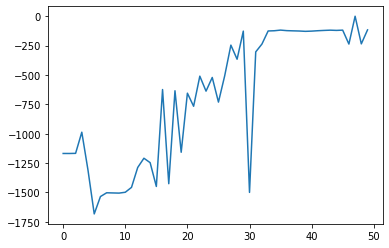

In [ ]:
ep_rewards = learn_env(env, agent, gamma, n_steps)
plt.plot(ep_rewards)

---
# Section 2: Ethics


## Part I: Relevance and efficiency of standards: local vs. global

By looking back at the discussions of the semester, it is possible to safely infer that the adoption and deployment of AI tools have ethical and societal implications. The adoption of standards is one approach that has been largely discussed in the U.S. and globally to deal with these implications and give AI developers and users some guidelines. 

To have an overview of which standards are being largely considered and their role, we will read [A Plan for Federal Engagement in Developing Technical Standards and Related Tools](https://www.nist.gov/system/files/documents/2019/08/10/ai_standards_fedengagement_plan_9aug2019.pdf) published by the National Institute of Standards and Technology from the Department of Commerce. 

Read the first excerpt (pages 7-16; PDF pages 9-18) which explains the US approach to standards.  Select one standard that you consider is the most relevant to an application covered in the semester. Offer your analysis of why this standard is important to guarantee the feasibility of this application.




In [ ]:
important_standard = "The text states that AI standards in Data, including big data analytics, data quality, data accessibility, and data privacy, are both being developed and currently available. Standardizing how we process, leverage, and provide our training data is hugely important for study reproducibility and AI transparency. By maintaining high Data standards, such as by democratizing \u201Ctools for capturing and representing knowledge and reasoning in AI systems\u201D (e.g., DeepLabCut), not only do we build in consistency and robustness into our algorithms, but we also increase accessibility to the general public, which may have positive downstream effects on AI trustworthiness. One good example is in facial recognition. If we were to build and open-source a facial recognition dataset sufficiently diverse, then it could potentially be less harmful." #@param {type:"string"}

try:t1;
except NameError: t1 = time.time()

Next, we will read excerpts from [The Chinese Approach to Artificial Intelligence: An Analysis of Policy, Ethics, and Regulation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469784) published in the AI & Society Journal of Knowledge, Culture and Communication and [Artificial Intelligence: A European approach to excellence and trust](https://ec.europa.eu/info/sites/info/files/commission-white-paper-artificial-intelligence-feb2020_en.pdf) published by the European Commission. 

These readings will bring some light into the discussions held in other parts of the world where AI adoption is largely discussed: the European Union and China. AI – such as most technologies – are hard to be considered in a jurisdictional cluster and different standards in different jurisdictions may cause relevant impacts in the development and adoption of a tool. 

Read Chapters 1 (pages 1-3; PDF pages 2-4) and 5 (pages 9-25; PDF pages 10-26) of [Artificial Intelligence: A European approach to excellence and trust](https://ec.europa.eu/info/sites/info/files/commission-white-paper-artificial-intelligence-feb2020_en.pdf) and then Section 4 (pages 19-28; PDF pages 19-28) of [The Chinese Approach to Artificial Intelligence: An Analysis of Policy, Ethics, and Regulation](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3469784).  Compare the EU and Chinese approaches to the standard analyzed above.

In [ ]:
eu_chinese_comparison = "Similarly, the European approach to AI standards also promotes data governance and transparency. This approach states that training datasets should be \u201Csufficiently broad\u201D and \u201Ccover all relevant scenarios needed to avoid dangerous situations.\u201D This point is extended to include gender, ethnicity, and other forms of identity or expression. Likewise, the European approach promotes accurate and well-documented recordkeeping of datasets and training methods. This is good. Importantly, they highlight the importance of human oversight: \u201Cthe output of the AI system does not become effective unless it has been previously reviewed and validated by a human.\u201D That is, despite the wish of some engineers to design \u201Cfully automated systems,\u201D it is crucial that a human always be \u201Cin-the-loop.\u201D They also include separate requirements for \u201Cbiometric ID.\u201D Likewise, the Chinese approach, and in particular, the Beijing AI Principles \u201Cfocus on doing good for humanity.\u201D The Chinese Association for Artificial Intelligence (CAII) has not established ethical principles.  The take on privacy is different, and this is largely due to an ingrained, cultural distinction: \u201Cthe Chinese people are\u2026 less sensitive about privacy.\u201D As such, there is disagreement over what type of personated data should be protected and regulated. How can we standardize across cultural differences? It might not be possible. They do, however, have principles in place for \u201CMedical Ethics,\u201D which manages to have seamlessly integrated AI in it.  " #@param {type:"string"}

try:t2;
except NameError: t2 = time.time()

Next, consider a specific application of deep learning.  (For example, select autonomous vehicles, medical diagnostic systems, facial recognition systems, or a similar autonomous system or application.)

Then, consider if there any differences between the US, EU and Chinese approaches. Which approach do you find is best suited to foster the development of the specific application you selected?  What are the implications of these different approaches (if any) to the development of the application you selected?  Would a global standardized approach be beneficial?  In what ways?

In [ ]:
better_approach = "Face recognition. Chinese approach is best suited to foster the development. European approach likely least suited given the specific requirements for biometric ID. These different approaches will lead to separate paths available for the deployment of AI and, on a longer time course, different rates of development of AI. " #@param {type:"string"}
global_standard = "A global standardized approach may not be beneficial. It might only be beneficial in standardizing how we regulate data concerns. But shouldn't that choice fall on the user?" #@param {type:"string"}

try:t3;
except NameError: t3 = time.time()

## Part II: Ethics and standards in the cost-benefit analysis of AI adoption in the private and public sectors

Next, consider the effects of the ethical dilemmas and the role the standards you studied in Part I above play in the decisions private companies and public officials need to make on whether or not to adopt an AI tool.

Do you think that the standards bring more security, transparency or trust into the decision-making process? Why? If you were in charge of deciding whether or not to develop and adopt the AI application you selected in Part I above in a private company, would you rather rely on standards or not? What if you were a public official making the decision to adopt such an application in a government agency? 

Moreover, reflect on the cost-benefit analysis entities – both private and public - need to make and how the standards play a role in these decisions. Do standards give decision makers more room to make an informed decision or not?


In [ ]:
part_II_response = "I certainly think the standards bring more security, transparency, and trust into the decision making process as they serve as checkpoints to reduce societal and personal harms of AI. If I were in charge of deciding whether or not to develop and adopt the AI application, I would much rather rely on standards. If I were a public official, it would be harder to make this decision for constituents, but for a government agency, I would also adopt these standards. By over-regulating AI, we might hinder its progress, with only a minimal payoff with respect to public trust. By underregulating it, we leave society at risk to potential harms, which can be grand. Although some sets of standards might stifle the space to make an informed decision (e.g. requiring a set of specific criteria for a particular form of data), standards, and more broadly guidelines, give decision makers more room to decide \"critically.\"" #@param {type:"string"}

try:t4;
except NameError: t4 = time.time()

---
# Submission

Once you're done, click on 'Share' and add the link to the box below. If you did not use CoLab, you can also upload the file or notebook in the form below.

In [ ]:
link = 'https://colab.research.google.com/drive/1jziEzCpAbebgGs6qQbZkoVyTSG_7mITG?usp=sharing' #@param {type:"string"}

In [ ]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame


#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: important_standard;
except NameError: important_standard = ""
try: eu_chinese_comparison
except NameError: eu_chinese_comparison = ""
try: better_approach
except NameError: better_approach = ""
try: global_standard
except NameError: global_standard = ""
try: part_II_response;
except NameError: part_II_response = ""
try: link;
except NameError: link = ""

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "important_standard": important_standard,
          "eu_chinese_comparison": eu_chinese_comparison,
          "better_approach": better_approach,
          "global_standard": global_standard,
          "part_II_response": part_II_response,
          "link": link}

src = "https://airtable.com/embed/shrKHlqxJWnwxMoCp?"


#now instead of the original source url, we do: src = prefill_form(src, fields)
display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))